# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 20)

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/14 20:33:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=[
    "SALARY",
    "REMOTE_TYPE_NAME",
    "DURATION",
    "MIN_YEARS_EXPERIENCE",
])
# from previous labs, we know that average salary of remote/on site/hybrid are quite different
categorical_cols = ["MIN_EDULEVELS_NAME"]
# we only have two numerical variables: Duration and YOE
continuous_cols = ["DURATION", "MIN_YEARS_EXPERIENCE"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=continuous_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features",
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df).select("SALARY", "features")
data.show(5,False)

+------+---------------------------+
|SALARY|features                   |
+------+---------------------------+
|192800|(7,[0,1,2],[55.0,6.0,1.0]) |
|125900|(7,[0,1,5],[18.0,12.0,1.0])|
|118560|(7,[0,1,3],[20.0,5.0,1.0]) |
|192800|(7,[0,1,2],[55.0,6.0,1.0]) |
|116500|(7,[0,1,5],[16.0,12.0,1.0])|
+------+---------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
data.count()

14416

In [4]:
# After dropping NA, we have only 14k samples.
# The dataset is small, so I chooe to split by 70/30.
# The seed is set to 42 for reproducibility
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(10217, 2)


[Stage 12:>                                                         (0 + 1) / 1]

(4199, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [5]:
# train a linear regression model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="SALARY", predictionCol="prediction")
lr_model = lr.fit(train_data)

25/04/14 20:34:23 WARN Instrumentation: [9f32da9e] regParam is zero, which might cause numerical instability and overfitting.
25/04/14 20:34:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/14 20:34:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
                                                                                

In [6]:
# model summary
summary = lr_model.summary
pd.DataFrame(dict(
    r2 = [summary.r2],
    rmse = [summary.rootMeanSquaredError],
    mae = [summary.meanAbsoluteError],
))

,r2,rmse,mae
0,0.375663,33844.806259,26245.314927


Interpretaion of model summaries:

- R-square 0.376: only 37% variation in salries can be explained by the model
- RMSE and MAE: very large, the model cannot give precise predictions

We have only take 3 variables as input, many other variables may play have significant influence on salaries.

In [7]:
# evaluate on test data
from pyspark.ml.evaluation import RegressionEvaluator
predictions = lr_model.transform(test_data)

# supported metrics: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
test_eval = dict()
for metric in ["rmse", "r2", "mae"]:
    evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    test_eval[metric] = [value]

pd.DataFrame.from_dict(test_eval)

,rmse,r2,mae
0,33134.004218,0.369048,25758.992898


Interpreations of results on test set:

- RMSE/MAE/R-Square are similar to the result on training set
- our model can genearlize to unseen data
- it has a consistent performance on train/test set

However, as we said before, the model cannot give a precise prediction and can only explain for 37% of the variation in the salary

In [8]:
# show intercept and coefficients
coefs = pd.DataFrame({
    "Intercept and Coefficients": [lr_model.intercept] + list(lr_model.coefficients),
    "Std Error": summary.coefficientStandardErrors,
    "t-stat": summary.tValues,
    "P-Value": summary.pValues
})
coefs.index = ["Intercept"] + [f"Feature {i+1}" for i in range(len(lr_model.coefficients))]
coefs

,Intercept and Coefficients,Std Error,t-stat,P-Value
Intercept,98812.681381,23.372127,-0.313938,7.535746e-01
Feature 1,-7.337397,106.549389,70.225843,0.000000e+00
Feature 2,7482.520653,8222.987333,-2.011999,4.424626e-02
Feature 3,-16544.642263,8257.008684,-1.785402,7.422586e-02
Feature 4,-14742.077469,8305.820642,-5.765106,8.397403e-09
Feature 5,-47883.936060,8337.317900,-5.931231,3.104303e-09
Feature 6,-49450.554328,8494.582812,3.285598,1.021094e-03
Feature 7,27909.782503,8239.300243,11.992849,0.000000e+00


GLR Summary Interpretations:

- Intercept:
  1. 98.8K is the base salary level when no information is provided.
  2. Small std-err means this result is reliable.
  3. However, this result is not the p-value 0.75 is too large, so it is not statistically significant.
- coefficient for duration:
  1. Salary is negatively correlated to the job post available duration.
  2. This means jobs that high paying jobs are quickly filled on the job market. While low paying jobs remains in the market for longer time.
  3. The absolute value 7.3 is very small, meaning one more day open leads to only 7.3 reduction in the salary.
  4. low standard error, the result is reliable.
  5. p < 0.001 highly statistical significance
- coefficient for years of experience:
  1. The coefficient is positive, so it is positively correlated to salary. This means the more experience one have, the higher salary they get.
  2. On average, one more year of experience leads to an increase of 7.5k in the salary.
  3. low standard error, the result is reliable.
  4. p < 0.001 highly statistical significance.
- coefficient for remote: (coefficients for 5 binary variables)
  1. On-site jobs are likely to have higher salaries (feature 7).
  2. The coefficient absolute values are very large, meaning that remote work type (remote/hybrid/onsite) greatly influences the salary.
  3. The standard errors are very large, meaning the results are mot reliable.
  4. all of the coefficients have p<0.001 so they are statistically significant.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


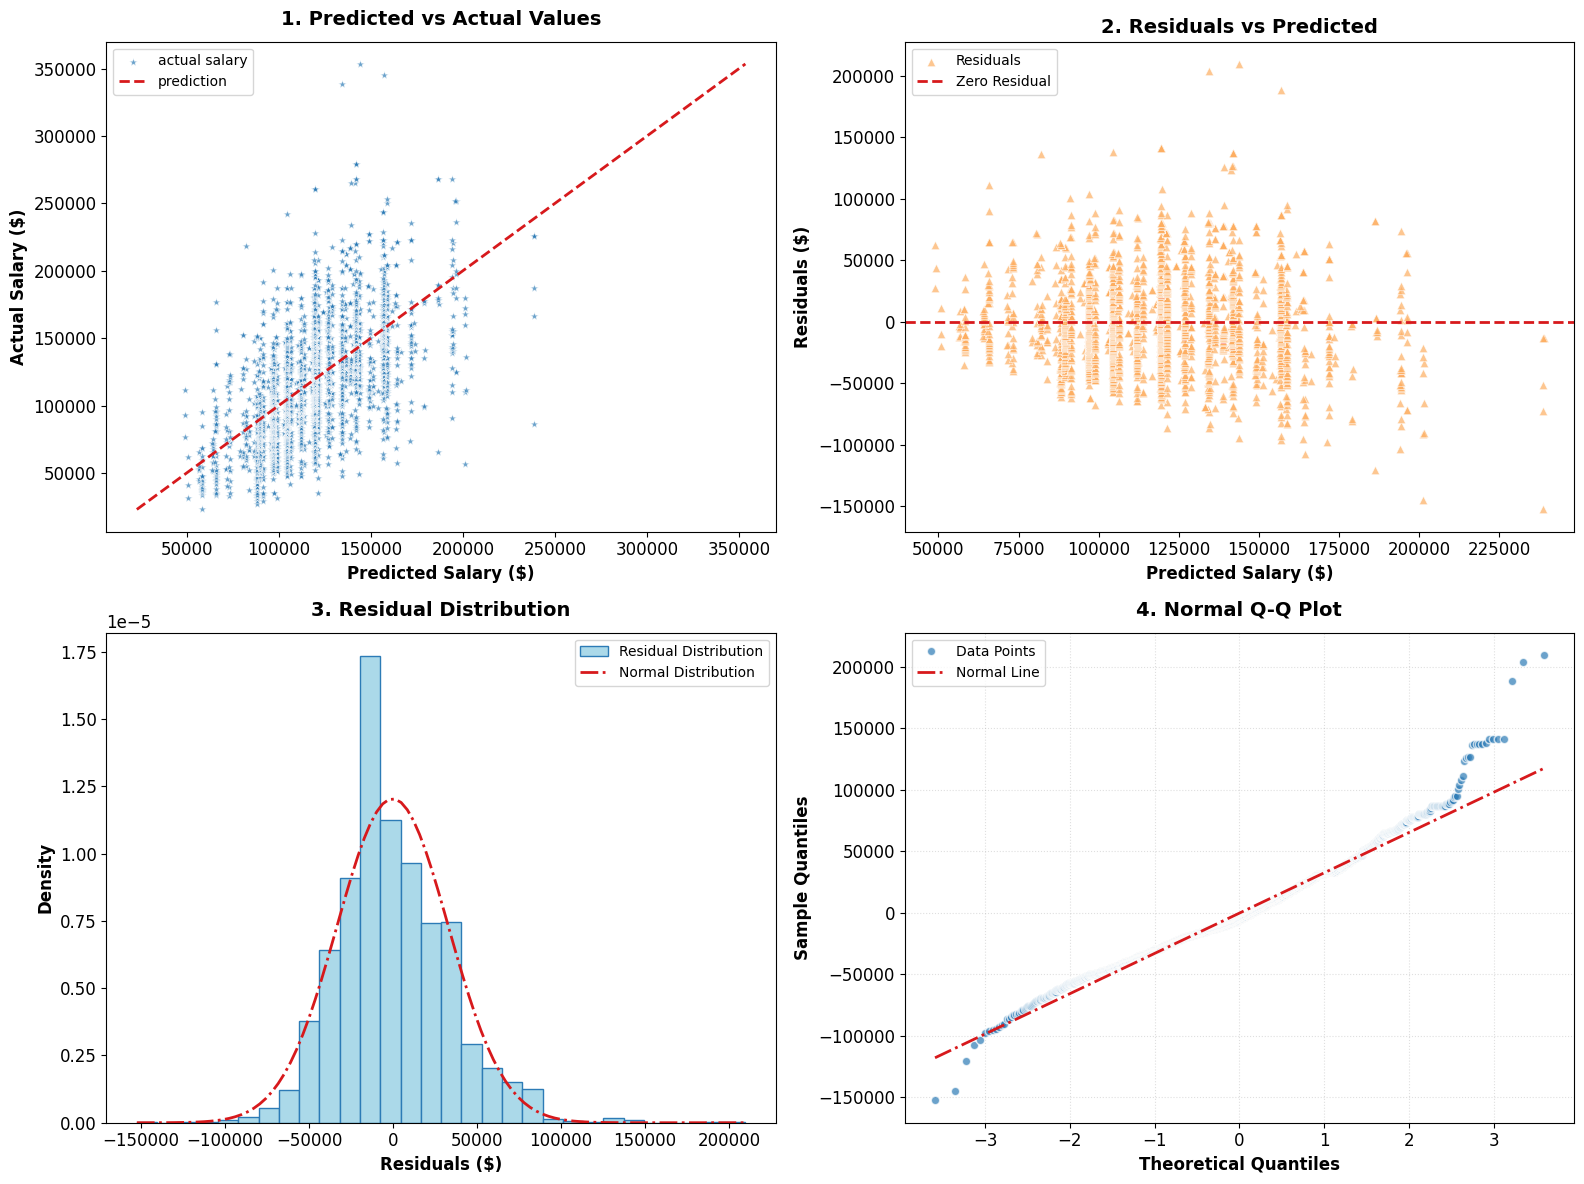

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load predictions from GLR model
df_pred = predictions.select(
    "SALARY",
    "prediction",
).toPandas()
# Compute residuals
df_pred["actual"] = df_pred["SALARY"]
df_pred["fitted"] = df_pred["prediction"]
df_pred["residuals"] = df_pred["actual"] - df_pred["fitted"]

# Standardized residuals
res_mean = df_pred["residuals"].mean() 
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# Square root of standardized residuals (for Scale-Location)
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))


# Set global style
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Clean, modern font
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'legend.fontsize': 10,
    'grid.linestyle': ':',
    'grid.alpha': 0.4
})

# Create figure
fig = plt.figure(figsize=(16, 12))

# 1. Predicted vs Actual Plot
plt.subplot(2,2, 1)
plt.scatter(
    df_pred["fitted"], 
    df_pred["actual"],
    c='#2c7bb6',  # change color
    marker='*', # change marker 
    edgecolors='w',
    linewidth=0.5,
    alpha=0.7,
    label='actual salary'
)

# Perfect prediction line
plt.plot(
    [df_pred["actual"].min(), df_pred["actual"].max()],
    [df_pred["actual"].min(), df_pred["actual"].max()],
    '--', 
    color='#d7191c',  # Red
    linewidth=2,
    label='prediction'
)

plt.title('1. Predicted vs Actual Values', pad=12)
plt.xlabel('Predicted Salary ($)')
plt.ylabel('Actual Salary ($)')
plt.legend(loc='upper left')

# 2. Residuals vs Predicted Plot
plt.subplot(2,2,2)
plt.scatter(
    df_pred["fitted"],
    df_pred["residuals"],
    c='#fdae61',  # Orange
    marker='^',
    edgecolors='w',
    linewidth=0.5,
    alpha=0.7,
    label='Residuals'
)

# Zero reference line
plt.axhline(
    y=0, 
    color='#d7191c',  # Red
    linestyle='--',
    linewidth=2,
    label='Zero Residual'
)

plt.title('2. Residuals vs Predicted')
plt.xlabel('Predicted Salary ($)')
plt.ylabel('Residuals ($)')
plt.legend(loc='upper left')

# 3. Histogram of Residuals
plt.subplot(2,2,3)
n_bins = min(30, len(df_pred) // 50)  # Dynamic bin calculation
plt.hist(
    df_pred["residuals"],
    bins=n_bins,
    color='#abd9e9',  # Light blue
    edgecolor='#2c7bb6',
    linewidth=1,
    density=True,
    label='Residual Distribution'
)

# Normal curve overlay
xmin, xmax = df_pred['residuals'].min(), df_pred['residuals'].max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df_pred["residuals"].mean(), df_pred["residuals"].std())
plt.plot(
    x, p,
    color='#d7191c',  # Red
    linewidth=2,
    linestyle='-.',
    label='Normal Distribution'
)

plt.title('3. Residual Distribution', pad=12)
plt.xlabel('Residuals ($)')
plt.ylabel('Density')
plt.legend(loc='upper right')

# 4. QQ Plot of Residuals
ax = plt.subplot(2,2,4)
stats.probplot(
    df_pred["residuals"], 
    dist="norm",
    plot=ax
)

# Style the default QQ plot
qq_line = ax.get_lines()[1]
qq_line.set_color('#d7191c')  # Red
qq_line.set_linestyle('-.')
qq_line.set_linewidth(2)

qq_points = ax.get_lines()[0]
qq_points.set_marker('o')
qq_points.set_markerfacecolor('#2c7bb6')  # Blue
qq_points.set_markeredgecolor('w')
qq_points.set_alpha(0.7)

ax.set_title('4. Normal Q-Q Plot', pad=12)
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
ax.grid(True)
ax.legend(['Data Points', 'Normal Line'], loc='upper left')

plt.title('4. Normal Q-Q Plot', pad=12)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend(['Data Points', 'Normal Line'], loc='upper left')


plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# supported metrics: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
rmse_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

pd.DataFrame.from_dict({
    'R-Square: Coefficient of Determination': [r2_eval.evaluate(predictions)],
    'RMSE: Root Mean Square Error': [rmse_eval.evaluate(predictions)],
})

,R-Square: Coefficient of Determination,RMSE: Root Mean Square Error
0,0.369048,33134.004218


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

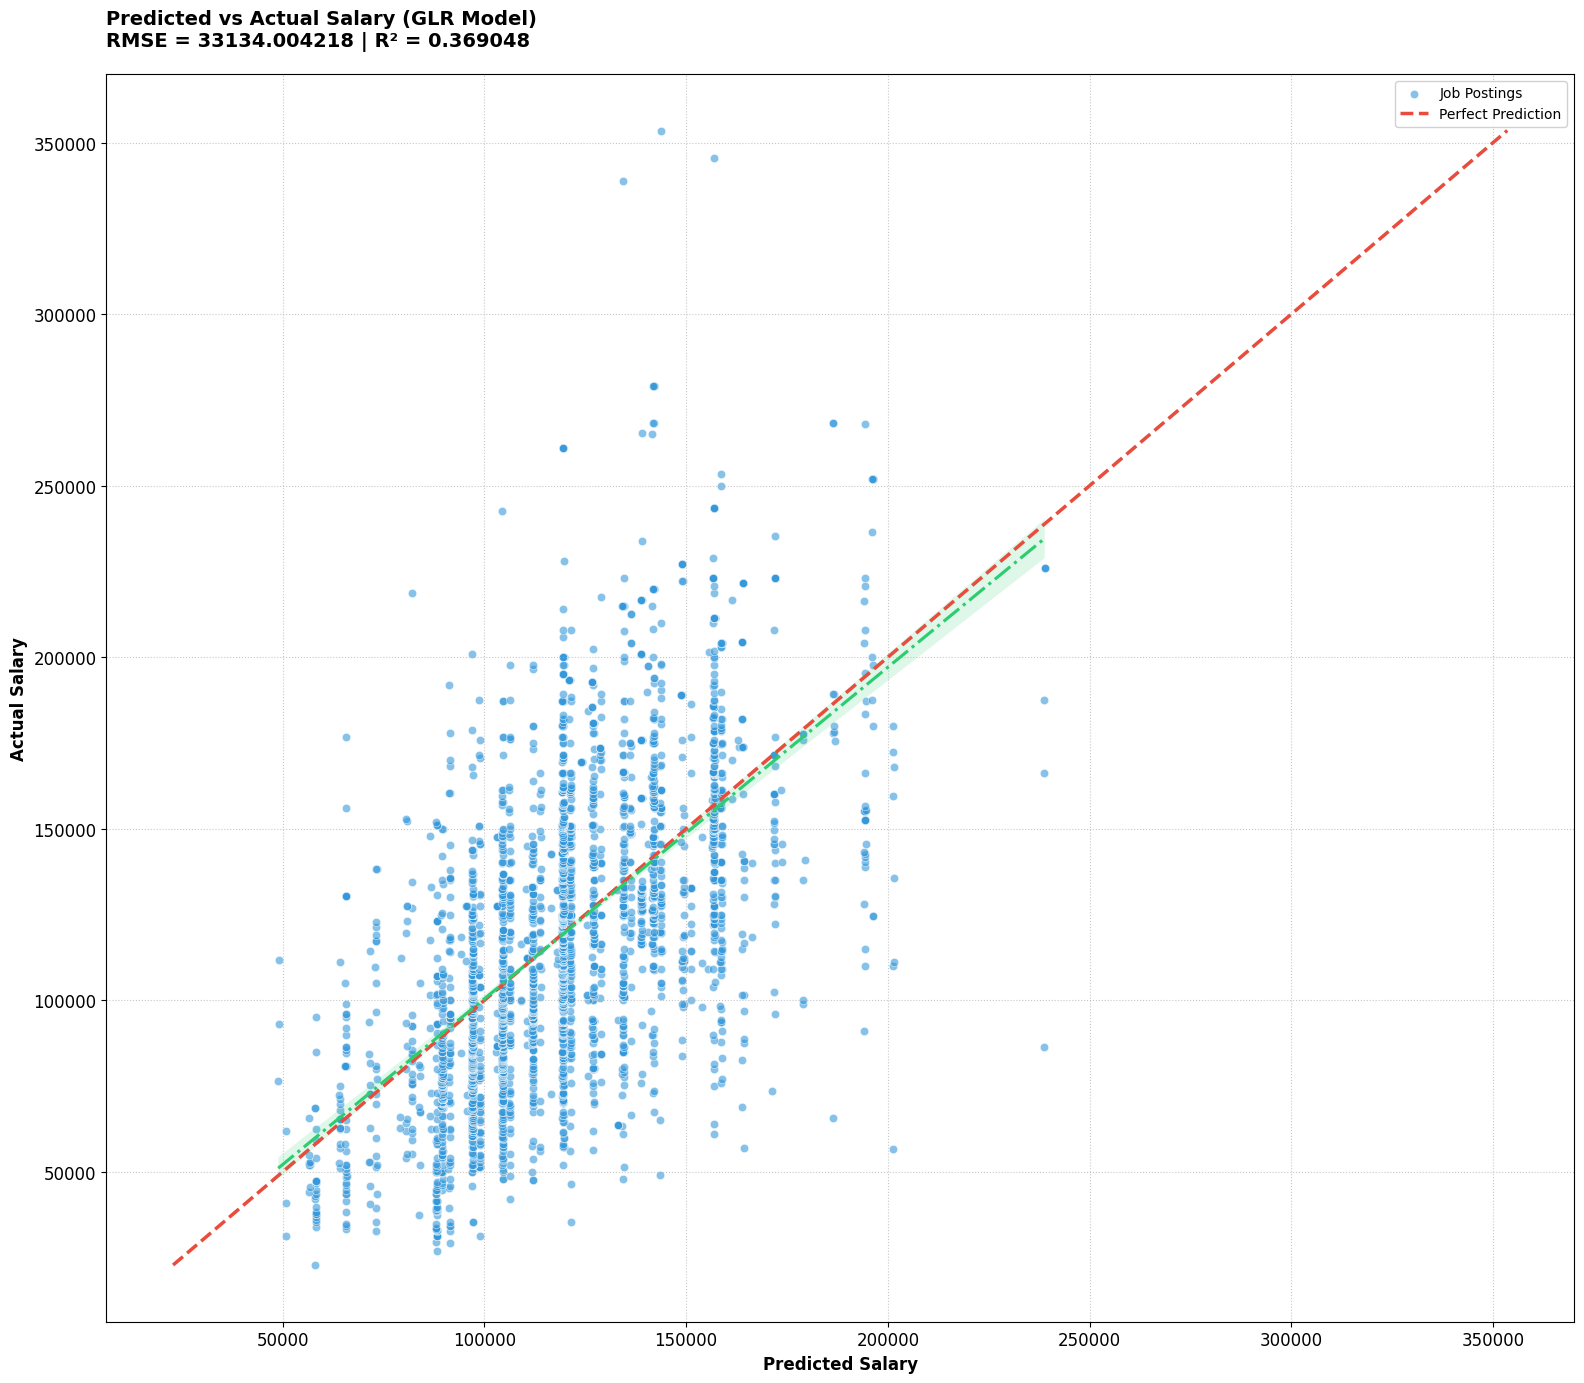

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.functions import col

# Convert GLR predictions to pandas
predictions_pdf = predictions.select(
    col("SALARY").alias("actual"),
    col("prediction").alias("predicted")
).toPandas()

rmse = 33134.004218
r2 = 0.369048

# Create plot with custom styling
plt.figure(figsize=(16, 14))

plt.scatter(
    predictions_pdf["predicted"],
    predictions_pdf["actual"],
    c='#3498db',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5,
    label='Job Postings'
)

# Perfect prediction line (y=x)
x_range = np.linspace(
    min(predictions_pdf[["actual", "predicted"]].min()),
    max(predictions_pdf[["actual", "predicted"]].max()),
    100
)
plt.plot(
    x_range, x_range,
    '--', 
    color='#e74c3c',
    linewidth=2.5,
    label='Perfect Prediction'
)

# Regression prediction line
sns.regplot(
    x="predicted",
    y="actual",
    data=predictions_pdf,
    scatter=False,
    color='#2ecc71',
    line_kws={'linestyle': '-.', 'label': 'Trend Line'}
)

plt.title(
    f"Predicted vs Actual Salary (GLR Model)\nRMSE = {rmse} | R² = {r2}",
    loc='left',
    pad=20,
    fontsize=14,
    fontweight='bold'
)
plt.xlabel("Predicted Salary", fontweight='bold')
plt.ylabel("Actual Salary", fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(frameon=True, framealpha=0.9)

plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png")
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
